<a href="https://colab.research.google.com/github/OJB-Quantum/Chinook-ARPES-Sim/blob/main/Chinook_ARPES_Simulation_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Angle-resolved photoemission spectroscopy (ARPES) simulation in Google Colab, using [Chinook](https://chinookpy.readthedocs.io/en/latest/index.html)

This Google Colab version is authored by Onri Jay Benally (2025), based on the examples found in (https://chinookpy.readthedocs.io/en/latest/tutorial.html).

In [1]:
# --- FULL PRE-IMPORT PATCH FOR CHINOOK ON COLAB (add this at the top) ---
import sys, warnings
import matplotlib.pyplot as plt
import collections, collections.abc

plt.rcParams['figure.dpi'] = 250

# 1) Drop Colab’s broken PyDrive import hook
sys.meta_path[:] = [m for m in sys.meta_path
                    if m.__class__.__name__ != "PyDriveImportHook"]

# 2) Silence ImportWarning and neuter filterwarnings()
warnings.filterwarnings("ignore", category=ImportWarning)
warnings.filterwarnings = lambda *args, **kwargs: None

# 3) Stub out plt.register_cmap if missing
if not hasattr(plt, "register_cmap"):
    plt.register_cmap = lambda *args, **kwargs: None

# 4) Restore Iterable in collections for Python ≥3.10
collections.Iterable = collections.abc.Iterable

# 5) Stub out set_window_title on the Agg canvas
from matplotlib.backend_bases import FigureCanvasBase
FigureCanvasBase.set_window_title = lambda self, title: None

In [2]:
!pip install chinook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 1.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import chinook
import chinook.matplotlib_plotter
import chinook.build_lib as build_lib
import chinook.operator_library as operators
from chinook.ARPES_lib import experiment
import matplotlib.pyplot as plt

# Chinook expects these '_alpha' maps—alias them to the normal ones
for base in ['RdBu','RdGy','RdPu','RdYlBu','RdYlGn','Spectral']:
    plt.register_cmap(name=f"{base}_alpha", cmap=plt.get_cmap(base))

In [4]:
# 3) Define a square‐lattice unit cell
a, c = 5.0, 5.0
avec = np.array([
    [np.sqrt(0.5)*a,  np.sqrt(0.5)*a, 0],
    [np.sqrt(0.5)*a, -np.sqrt(0.5)*a, 0],
    [0,              0,              c]
])  # lattice vectors :contentReference[oaicite:1]{index=1}

In [5]:
# 4) Build k‐path object
kpoints = np.array([[0.5,0.5,0.0],
                    [0.0,0.0,0.0],
                    [0.5,-0.5,0.0]])
labels  = np.array(['$M_x$', '$\\Gamma$', '$M_y$'])
kdict   = {
    'type':   'F',
    'avec':   avec,
    'pts':    kpoints,
    'grain':  200,
    'labels': labels
}
k_object = build_lib.gen_K(kdict)  # high-symmetry path :contentReference[oaicite:2]{index=2}

In [6]:
# 5) Define basis with spin–orbit coupling
spin = {
    'bool': True,
    'soc':  True,
    'lam':  {0: 0.5}
}
Sb1 = np.array([0.0, 0.0, 0.0])
Sb2 = np.array([np.sqrt(0.5)*a, 0.0, 0.0])
basis = {
    'atoms': [0, 0],
    'Z':     {0: 51},
    'orbs':  [['51x','51y','51z'], ['51x','51y','51z']],
    'pos':   [Sb1, Sb2],
    'spin':  spin
}
basis_object = build_lib.gen_basis(basis)  # full 5p basis on two Sb atoms :contentReference[oaicite:3]{index=3}

In [7]:
# 6) Build Slater–Koster Hamiltonian
Ep, Vpps, Vppp = 0.7, 0.25, -1.0
# (a) nearest + next-nearest neighbour
V1 = {'051': Ep,    '005511S': Vpps,    '005511P': Vppp}
V2 = {'005511S': Vpps/a, '005511P': Vppp/a}
VSK    = [V1, V2]
cutoff = [0.8*a, 1.1*a]

hamiltonian = {
    'type':   'SK',
    'V':      VSK,
    'avec':   avec,
    'cutoff': cutoff,
    'renorm': 1.0,
    'offset': 0.0,
    'tol':    1e-4,
    'spin':   spin
}

In [8]:
# Generate tight-binding model
TB = build_lib.gen_TB(basis_object, hamiltonian, k_object)

<Axes: ylabel='Energy (eV)'>

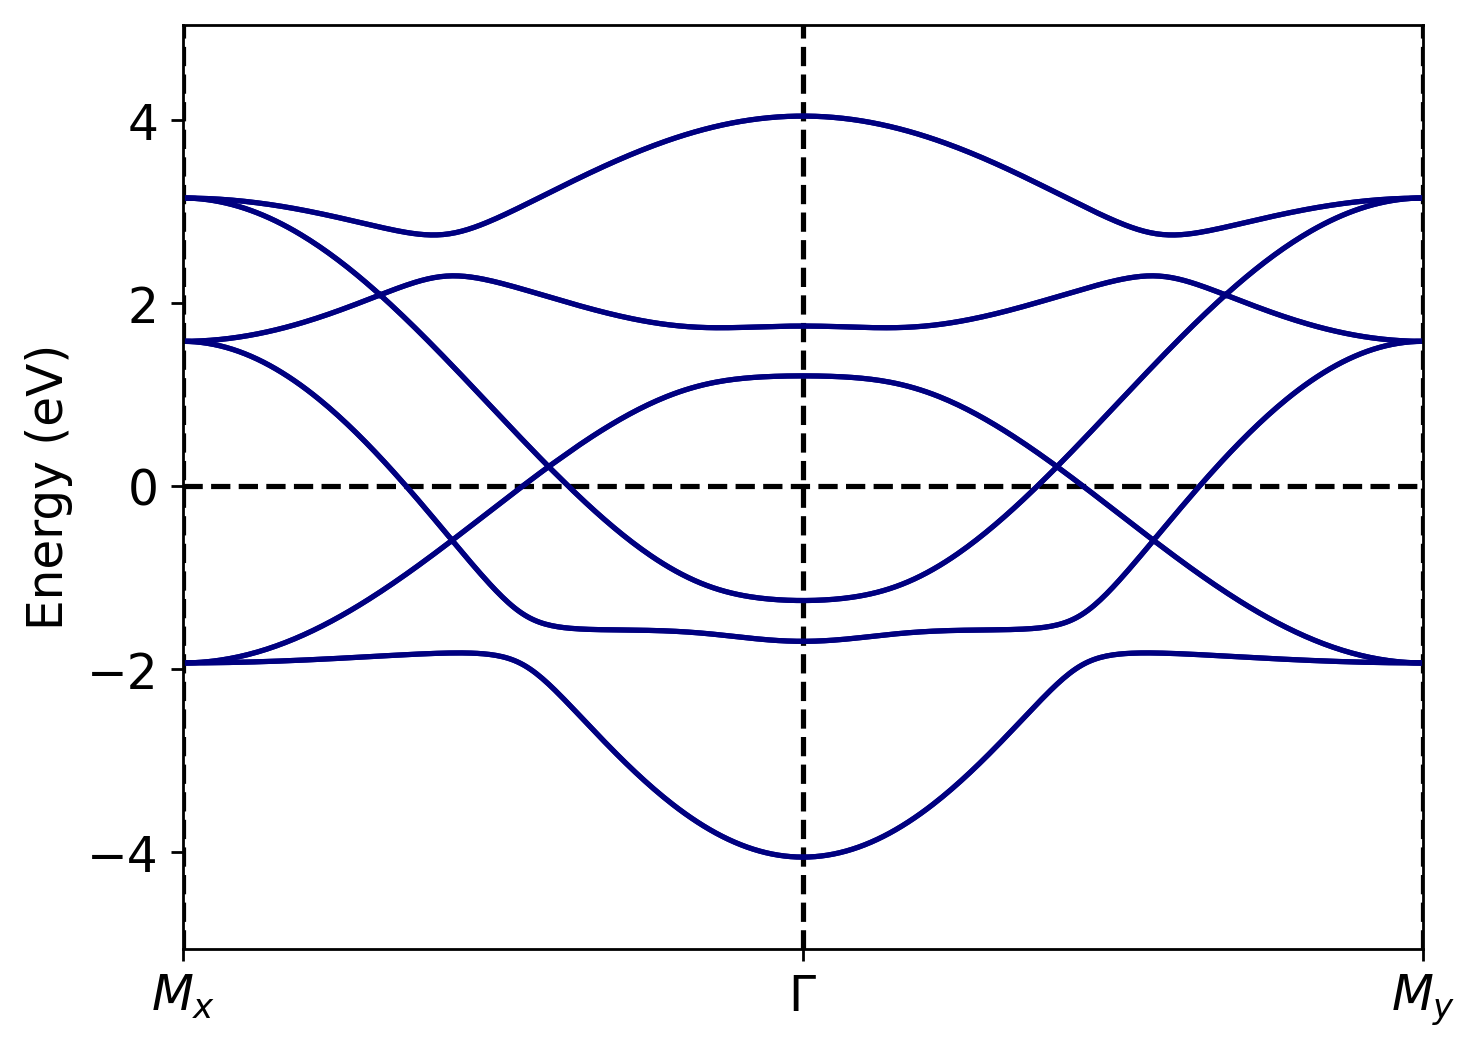

In [9]:
# 8) Diagonalize & plot band structure
TB.Kobj = k_object
TB.solve_H()
TB.plotting()  # shows dispersion along M–Γ–M :contentReference[oaicite:5]{index=5}

In [10]:
# 9) Print basis summary
TB.print_basis_summary()  # orbital ordering for fat-bands :contentReference[oaicite:6]{index=6}

 Index | Atom | Label | Spin |     Position     
    0  |   0  |51x    |  -0.5| 0.000,0.000,0.000
    1  |   0  |51y    |  -0.5| 0.000,0.000,0.000
    2  |   0  |51z    |  -0.5| 0.000,0.000,0.000
    3  |   0  |51x    |  -0.5| 3.536,0.000,0.000
    4  |   0  |51y    |  -0.5| 3.536,0.000,0.000
    5  |   0  |51z    |  -0.5| 3.536,0.000,0.000
    6  |   0  |51x    |   0.5| 0.000,0.000,0.000
    7  |   0  |51y    |   0.5| 0.000,0.000,0.000
    8  |   0  |51z    |   0.5| 0.000,0.000,0.000
    9  |   0  |51x    |   0.5| 3.536,0.000,0.000
   10  |   0  |51y    |   0.5| 3.536,0.000,0.000
   11  |   0  |51z    |   0.5| 3.536,0.000,0.000


projections need to be passed as list or array of type [index,projection]
projections need to be passed as list or array of type [index,projection]
projections need to be passed as list or array of type [index,projection]


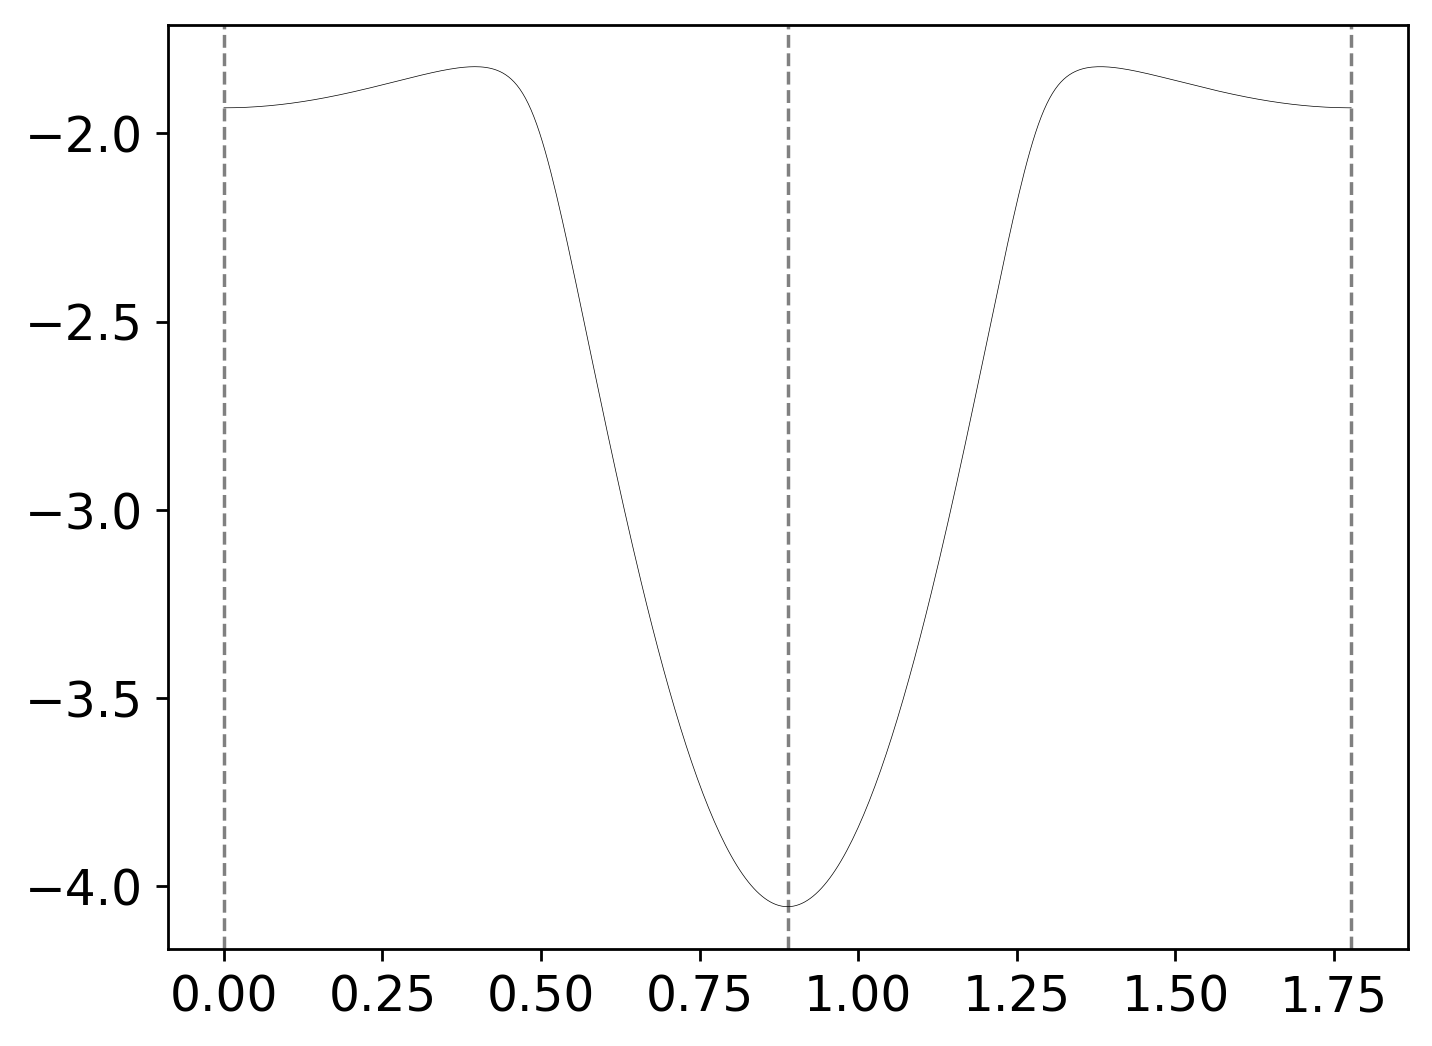

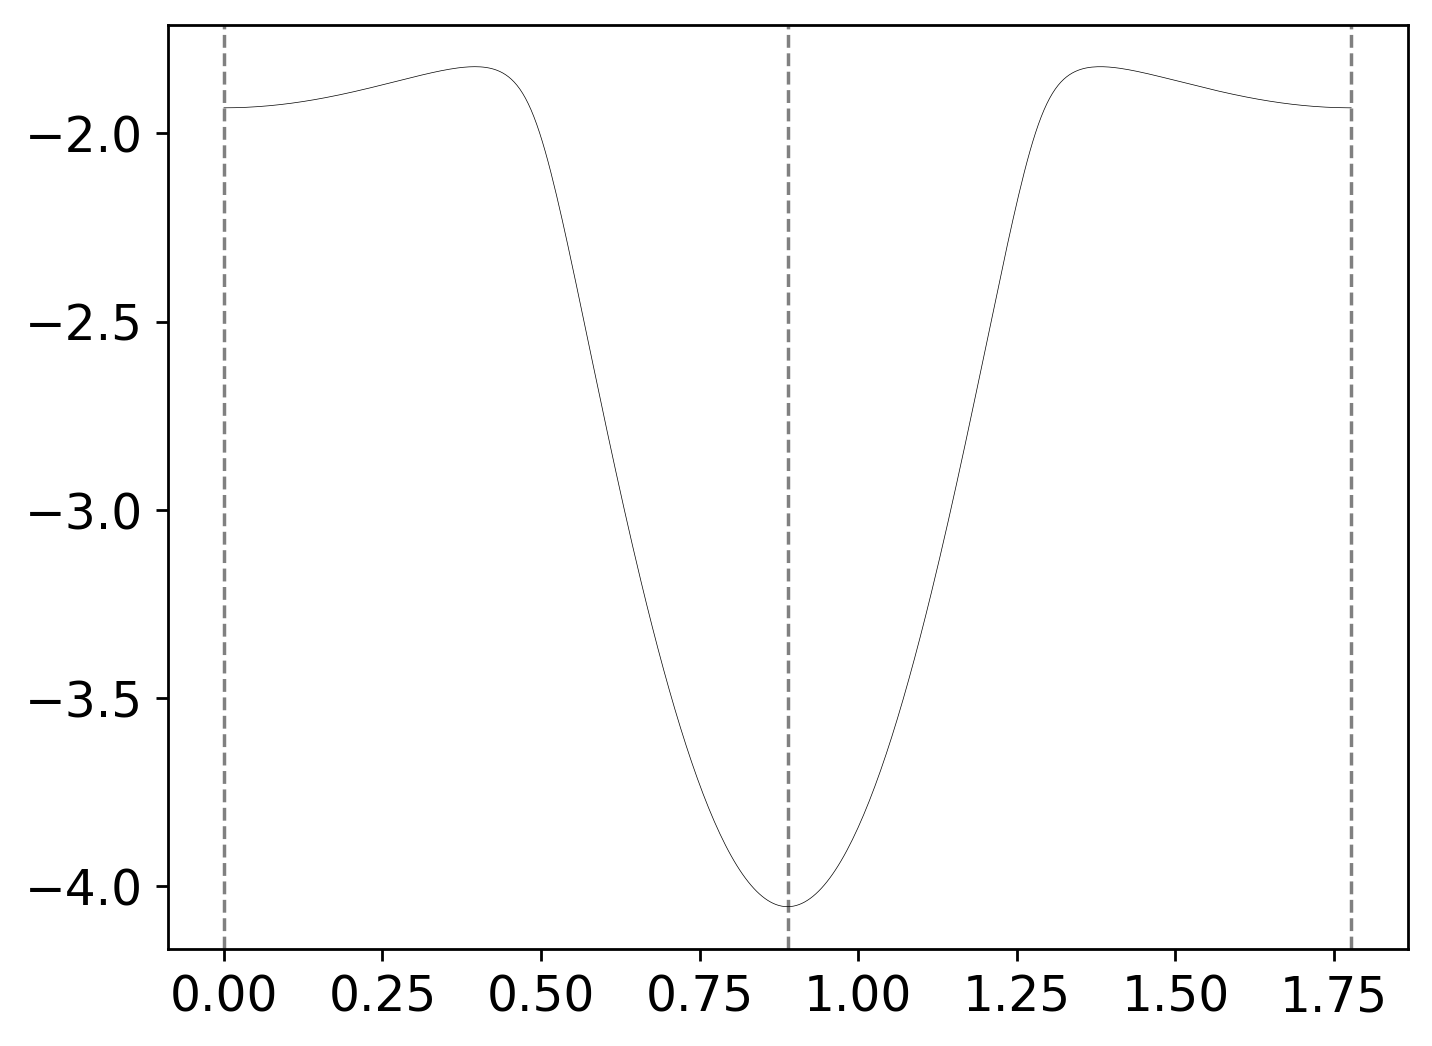

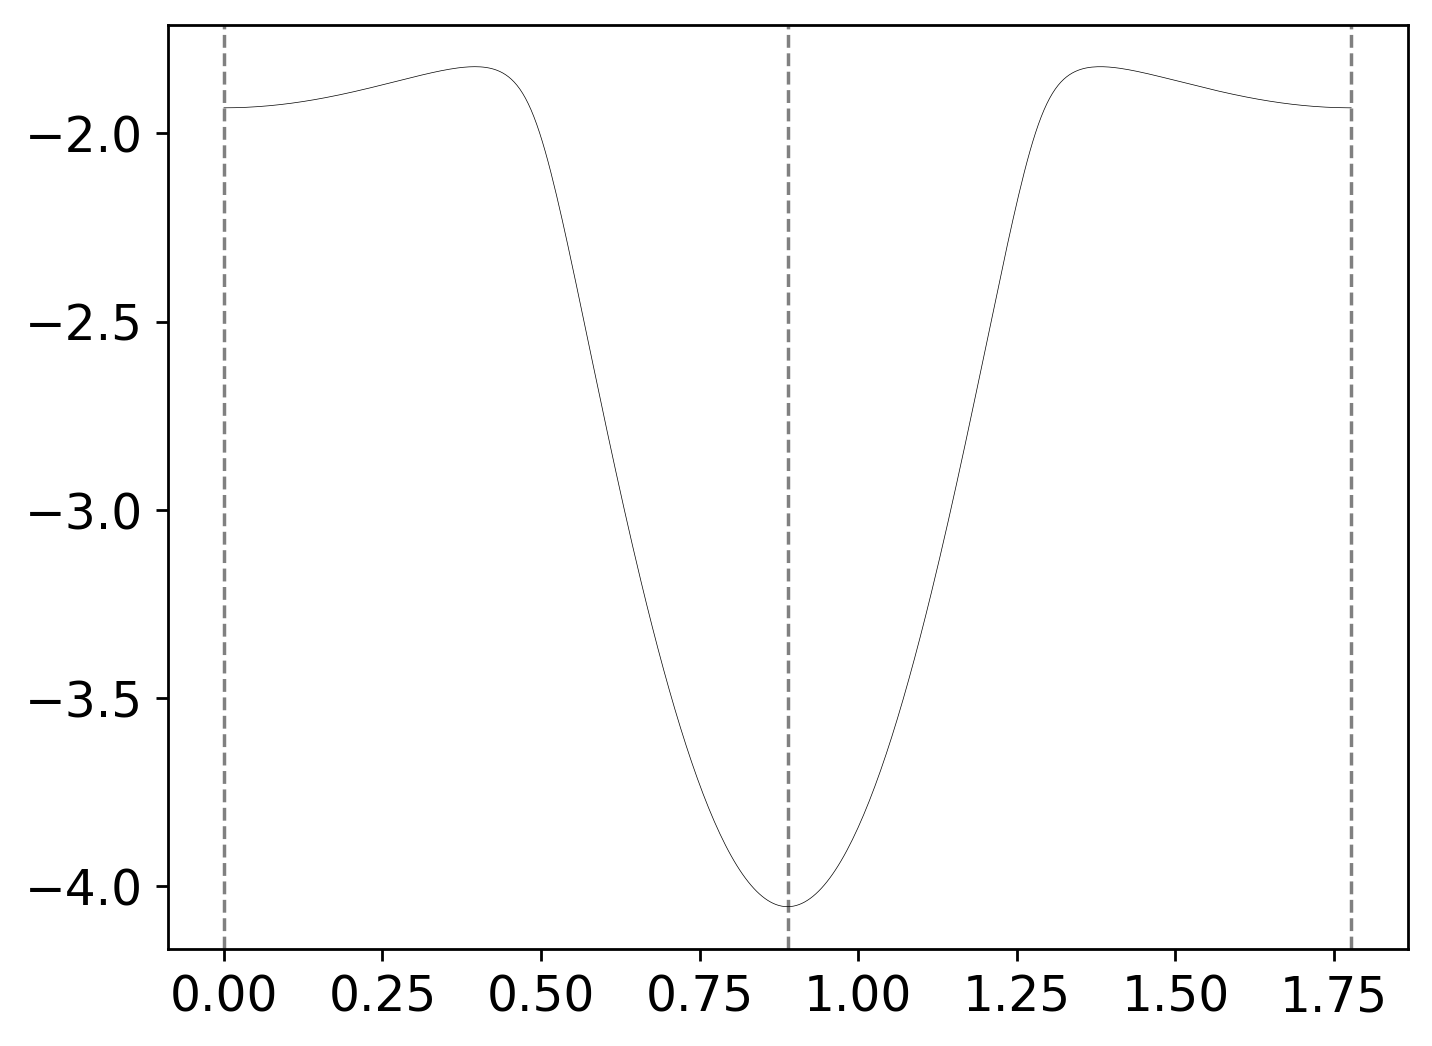

In [11]:
# 10) Plot fat-bands (px, py, pz)
px = operators.fatbs(proj=[0,3,6,9],   TB=TB, Elims=(-5,5), degen=True)
py = operators.fatbs(proj=[1,4,7,10],  TB=TB, Elims=(-5,5), degen=True)
pz = operators.fatbs(proj=[2,5,8,11],  TB=TB, Elims=(-5,5), degen=True)

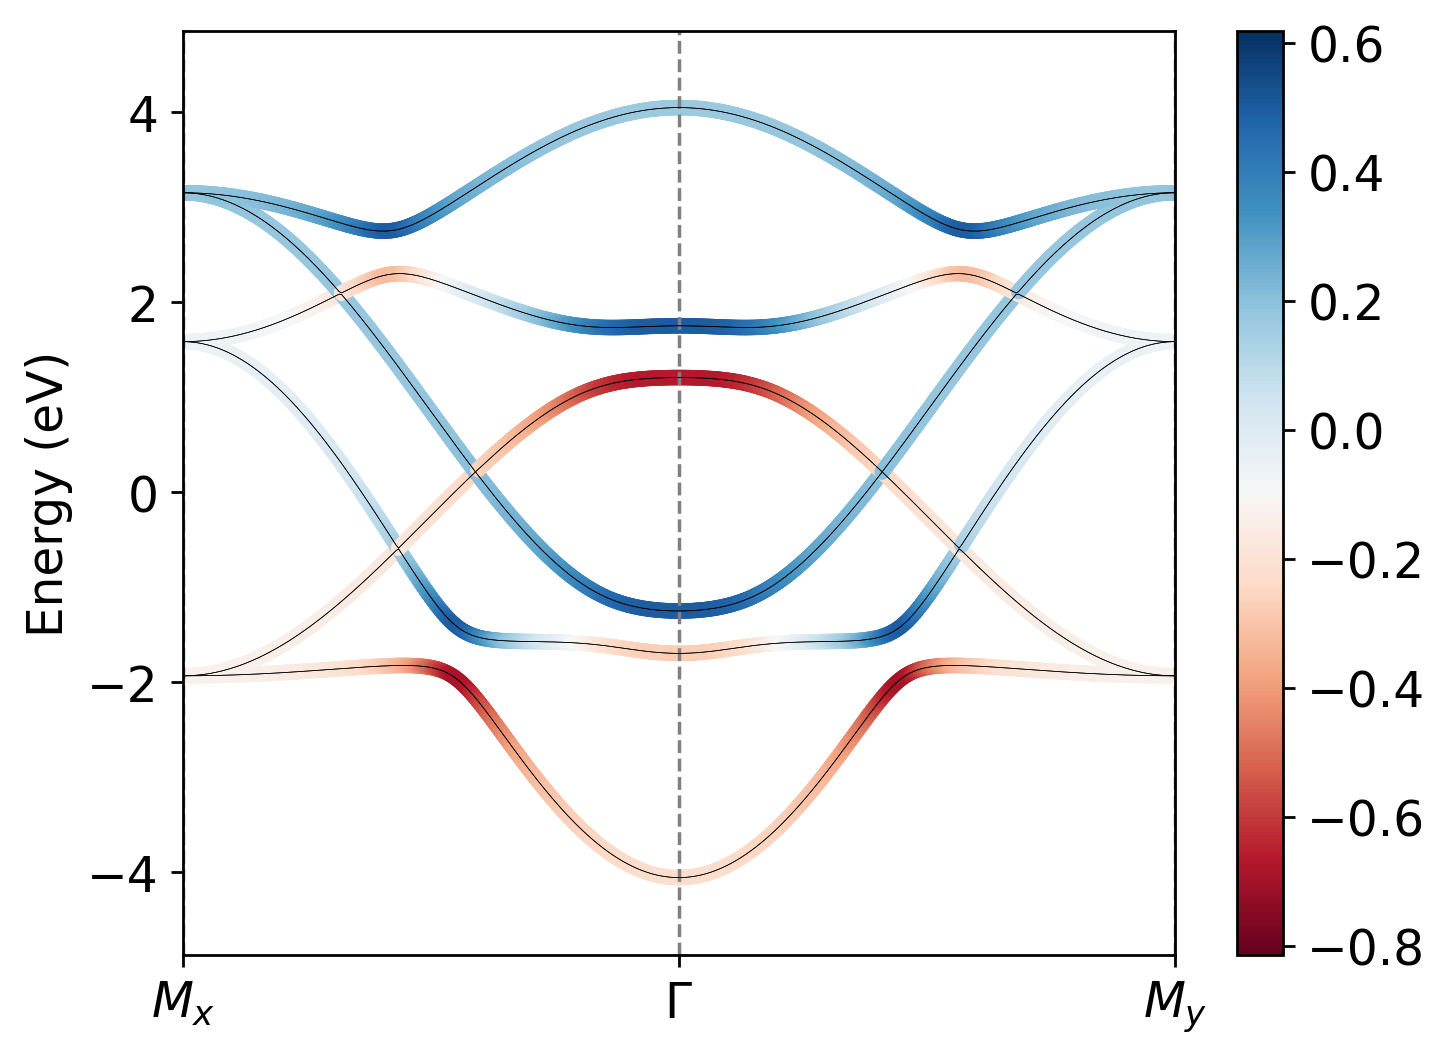

In [12]:
# 11) Compute ⟨L·S⟩ along bands and plot with a valid cmap
LdS_matrix = operators.LSmat(TB)            # ← make sure this runs first
LdS = operators.O_path(
    LdS_matrix,
    TB,
    degen=True,
    colourmap="RdBu",                       # use a built-in cmap
)

In [13]:
# 12) Set up ARPES experiment parameters
arpes = {
    'cube':      {'X':[-0.628,0.628,300],
                  'Y':[-0.628,0.628,300],
                  'E':[-0.05,0.05,50],
                  'kz':0.0},
    'hv':        100,
    'T':         10,
    'pol':       np.array([1,0,-1]),
    'SE':        ['constant', 0.02],
    'resolution':{'E':0.02, 'k':0.02}
}
arpes_experiment = experiment(TB, arpes)
arpes_experiment.datacube()  # build matrix-element cube :contentReference[oaicite:7]{index=7}

Initiate diagonalization: 
Large memory load: splitting diagonalization into 3 segments
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


True

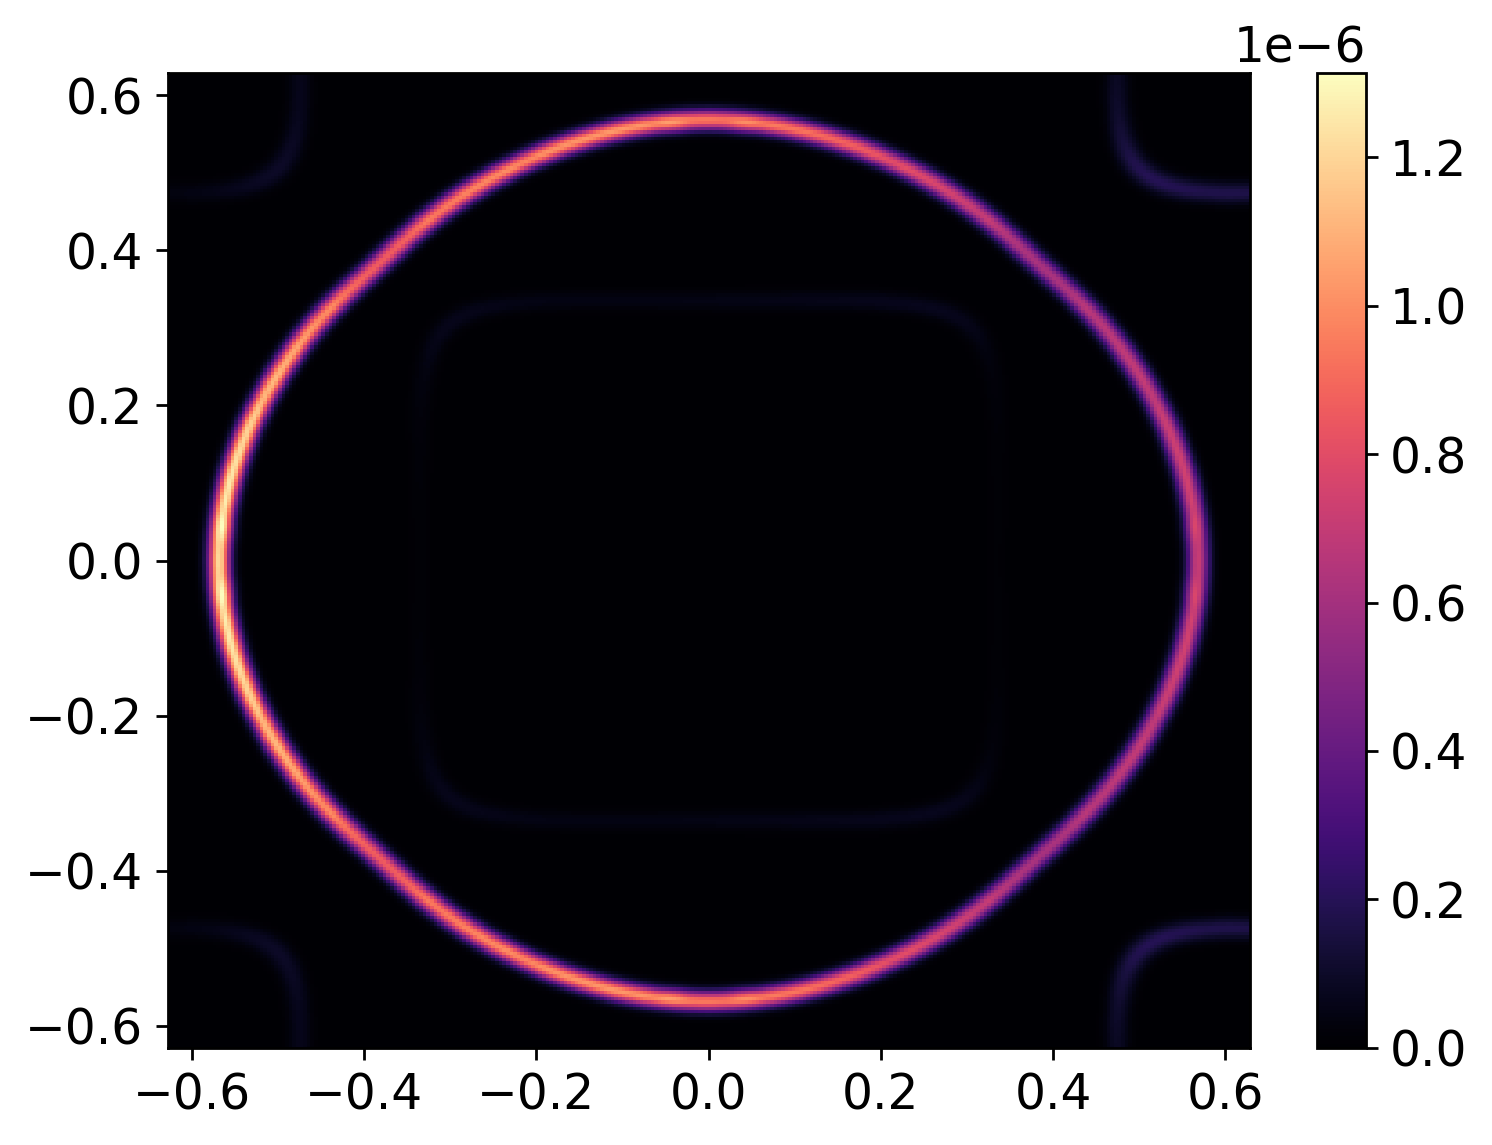

In [14]:
# 13) Plot constant-energy contour at EF
I, Ig, ax = arpes_experiment.spectral(slice_select=('w',0.0))

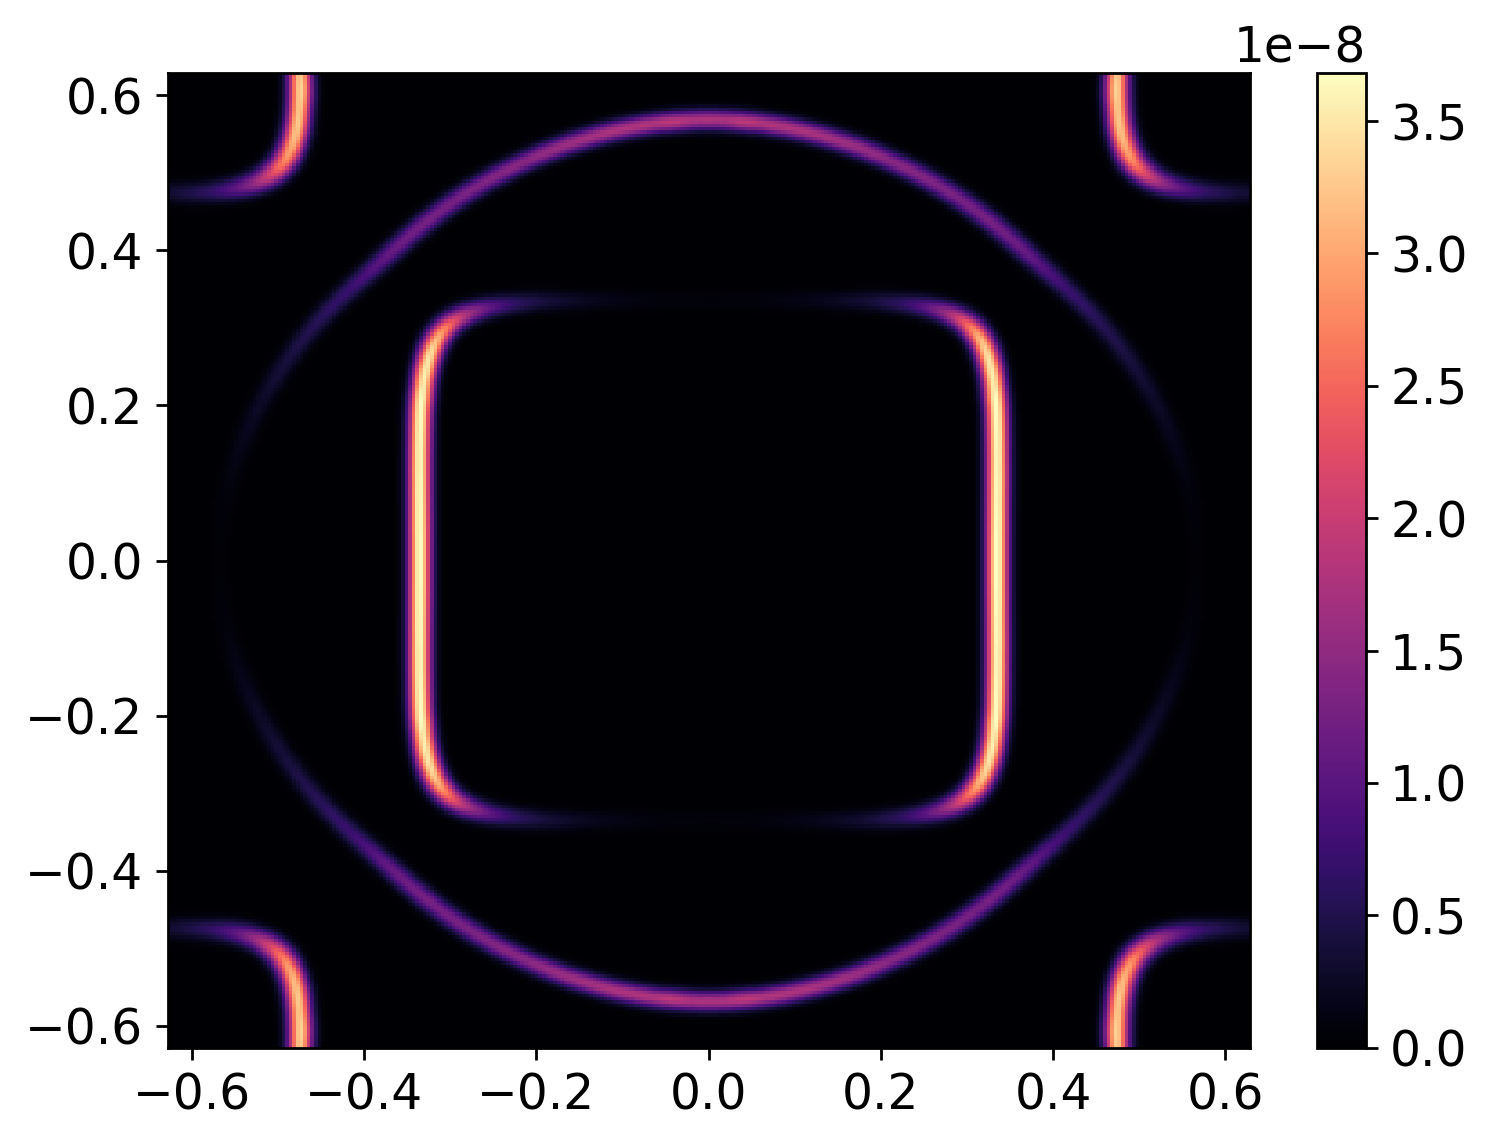

In [15]:
# 14) Rotate polarization in-plane and re-plot
arpes['pol'] = np.array([0,1,0])
_ = arpes_experiment.spectral(arpes, slice_select=('w',0))

Initiate diagonalization: 
Large memory load: splitting diagonalization into 3 segments
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


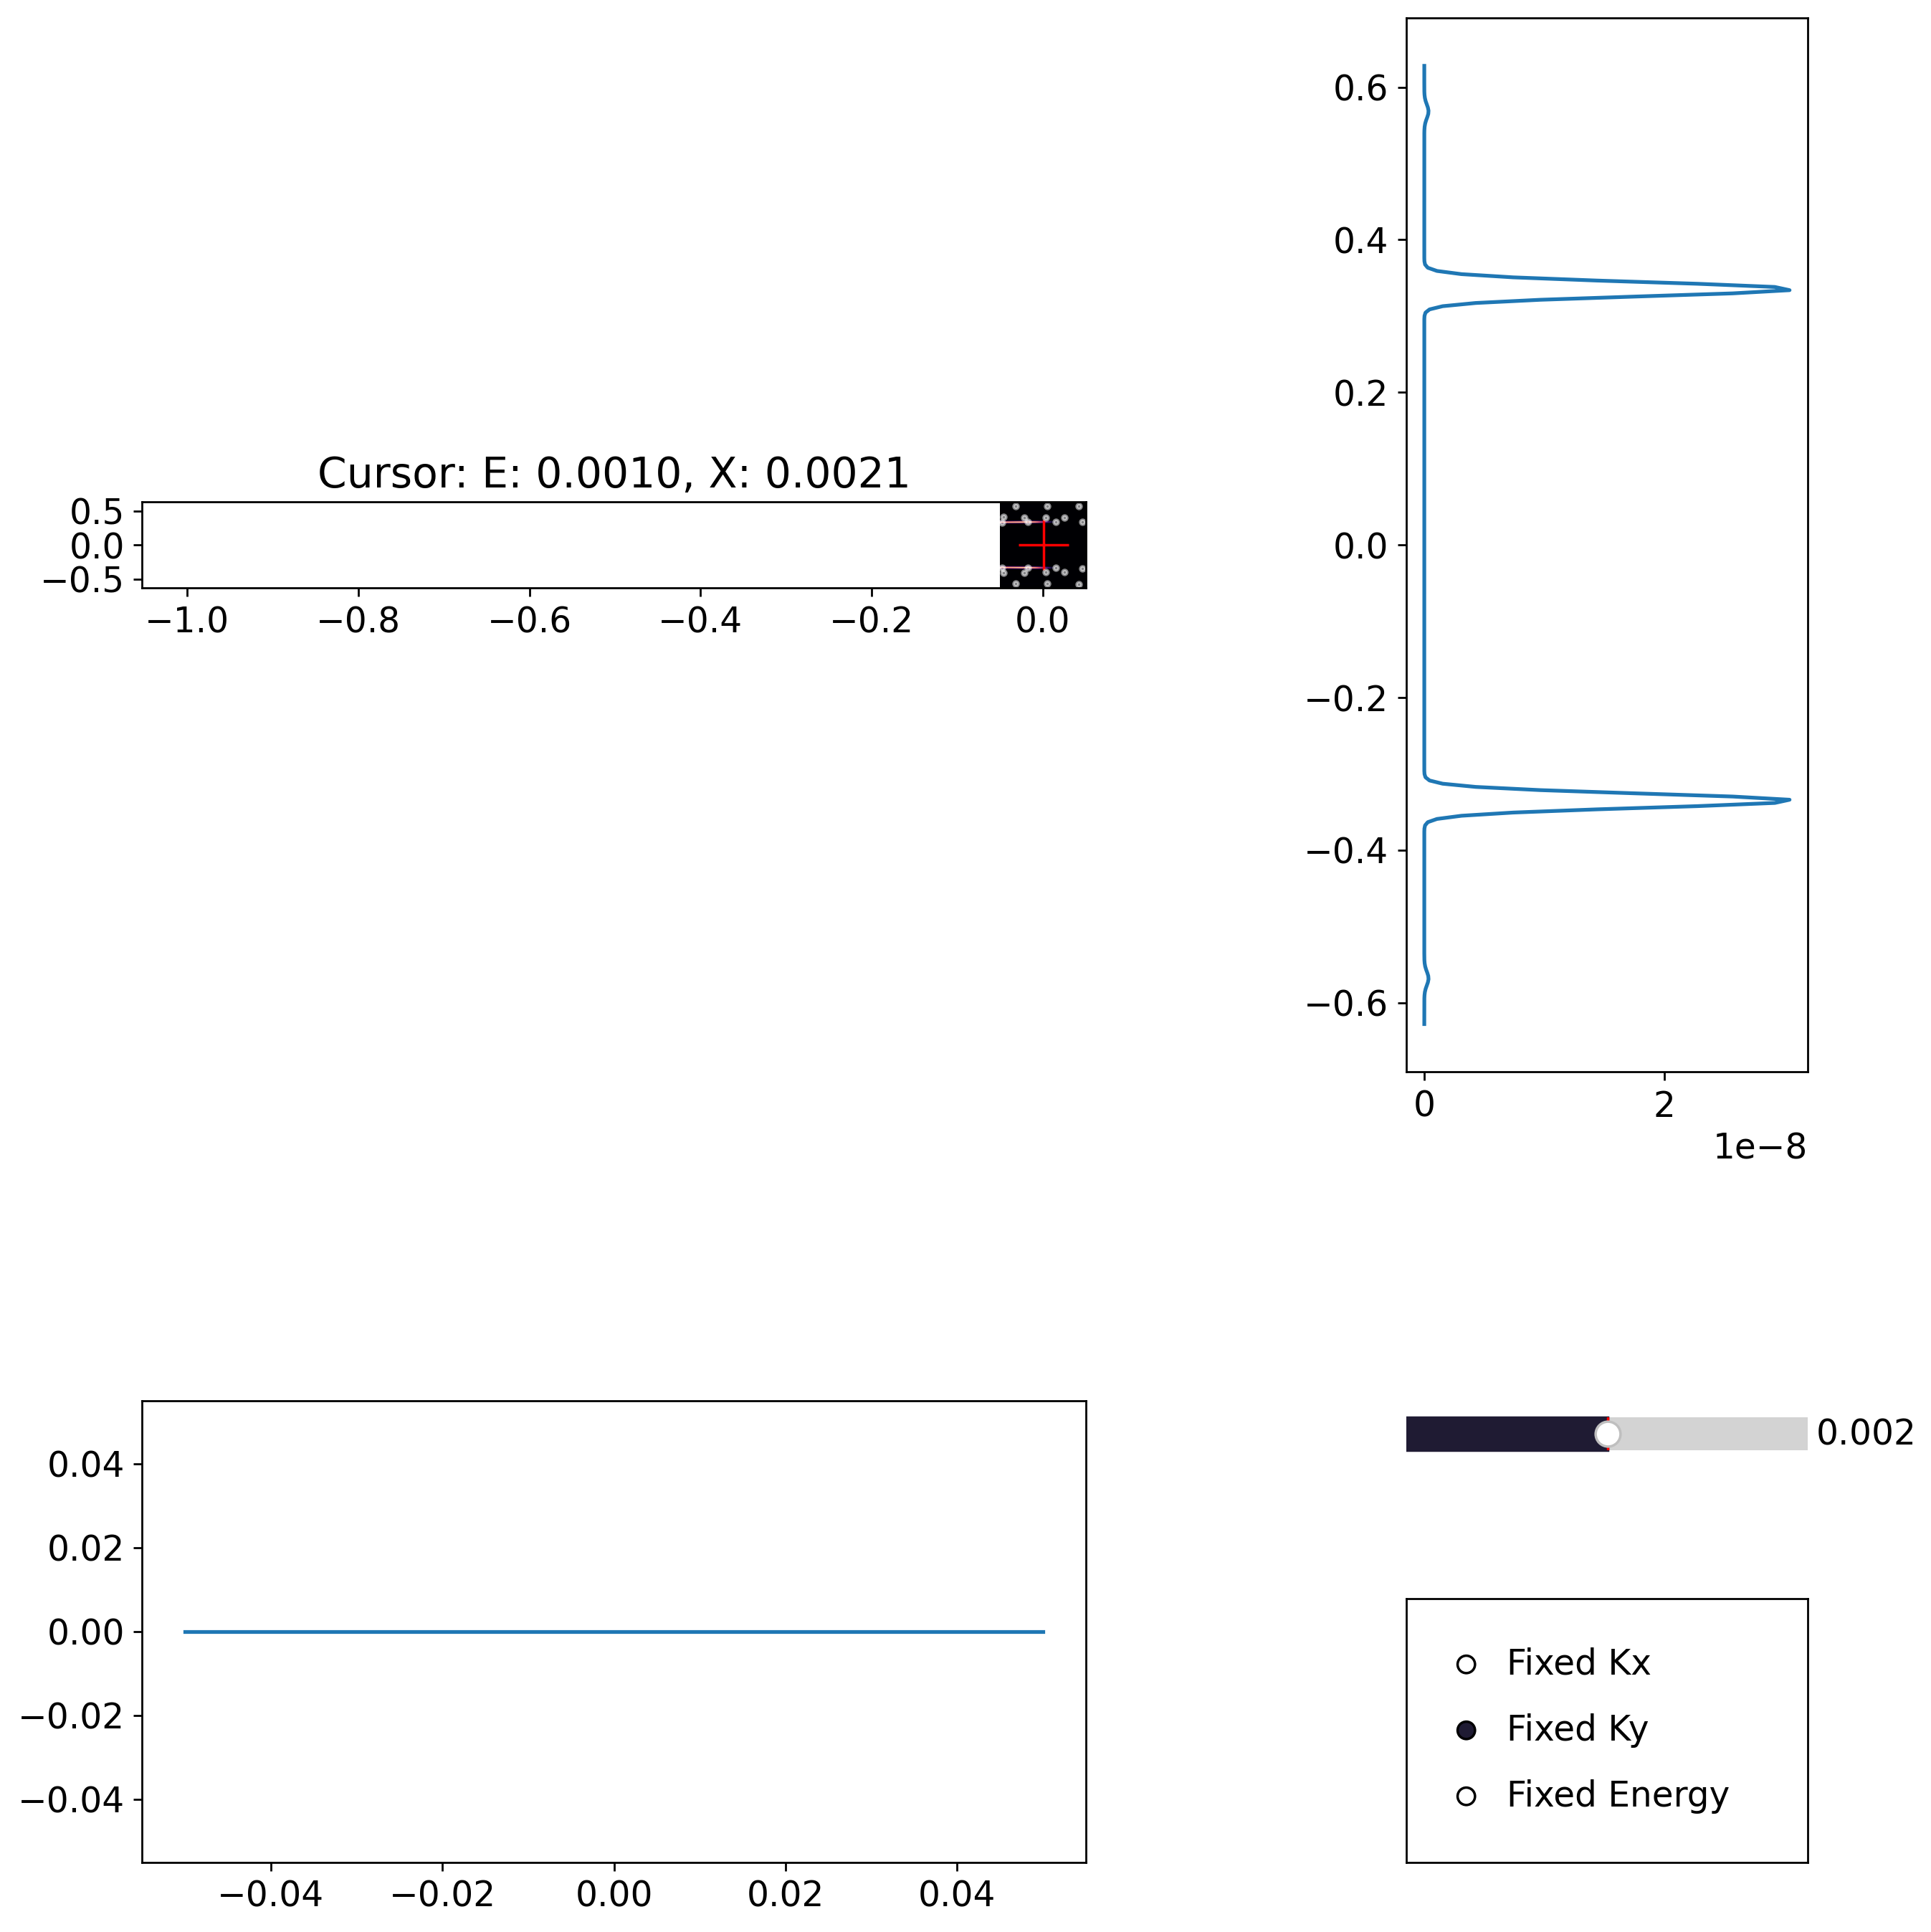

In [16]:
# 15) Build your TB and ARPES objects
#    (run all the earlier tutorial cells up through .datacube())
#    e.g.:
Tb = build_lib.gen_TB(basis_object, hamiltonian, k_object)
Tb.Kobj = k_object; Tb.solve_H()
arpes_experiment = experiment(Tb, arpes)

# 16) Finally launch the GUI
interface = chinook.matplotlib_plotter.interface(arpes_experiment)

Initiate diagonalization: 
Diagonalization Complete.
Begin computing matrix elements: 
||||||||||||||||||||||||||||||100%
Done matrix elements


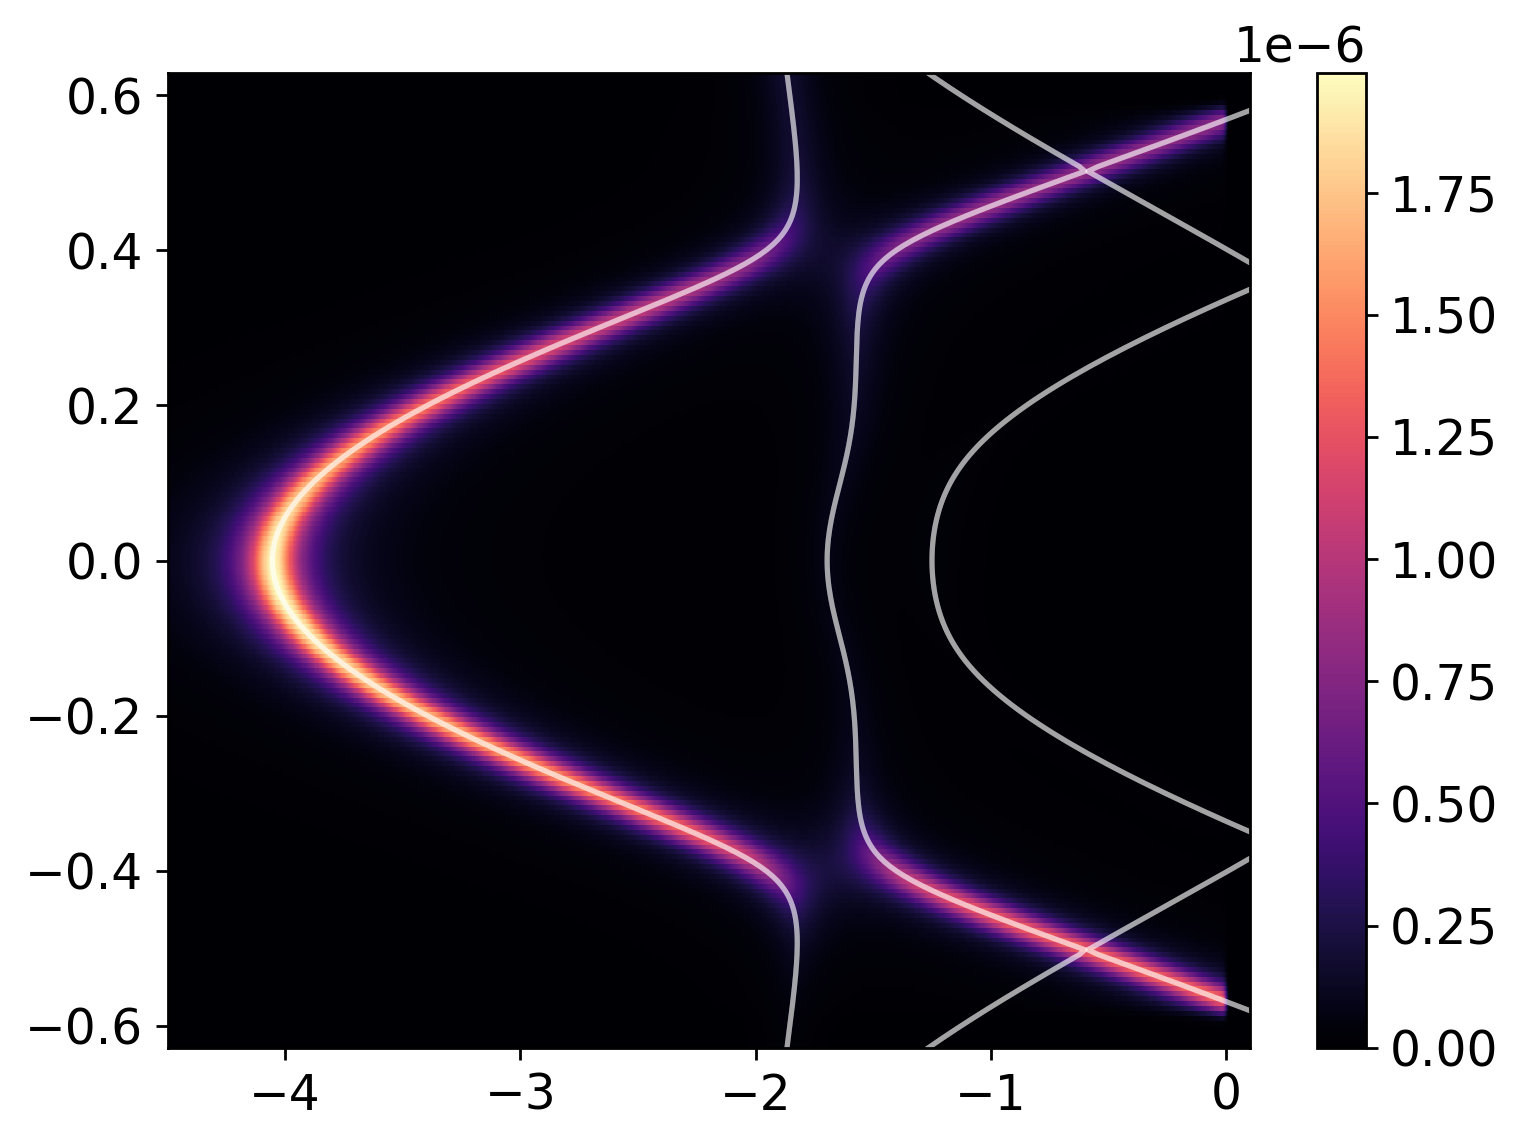

In [17]:
# 17) Compute over a wider momentum/energy domain
arpes.update({
    'cube':{'X':[-0.628,0.628,200],
            'Y':[0,0,1],
            'kz':0,
            'E':[-4.5,0.1,1000]},
    'SE':['constant',0.1],
    'pol':np.array([1,0,-1])
})
arpes_experiment = experiment(TB, arpes)
arpes_experiment.datacube()
_ = arpes_experiment.spectral(slice_select=('y',0), plot_bands=True)

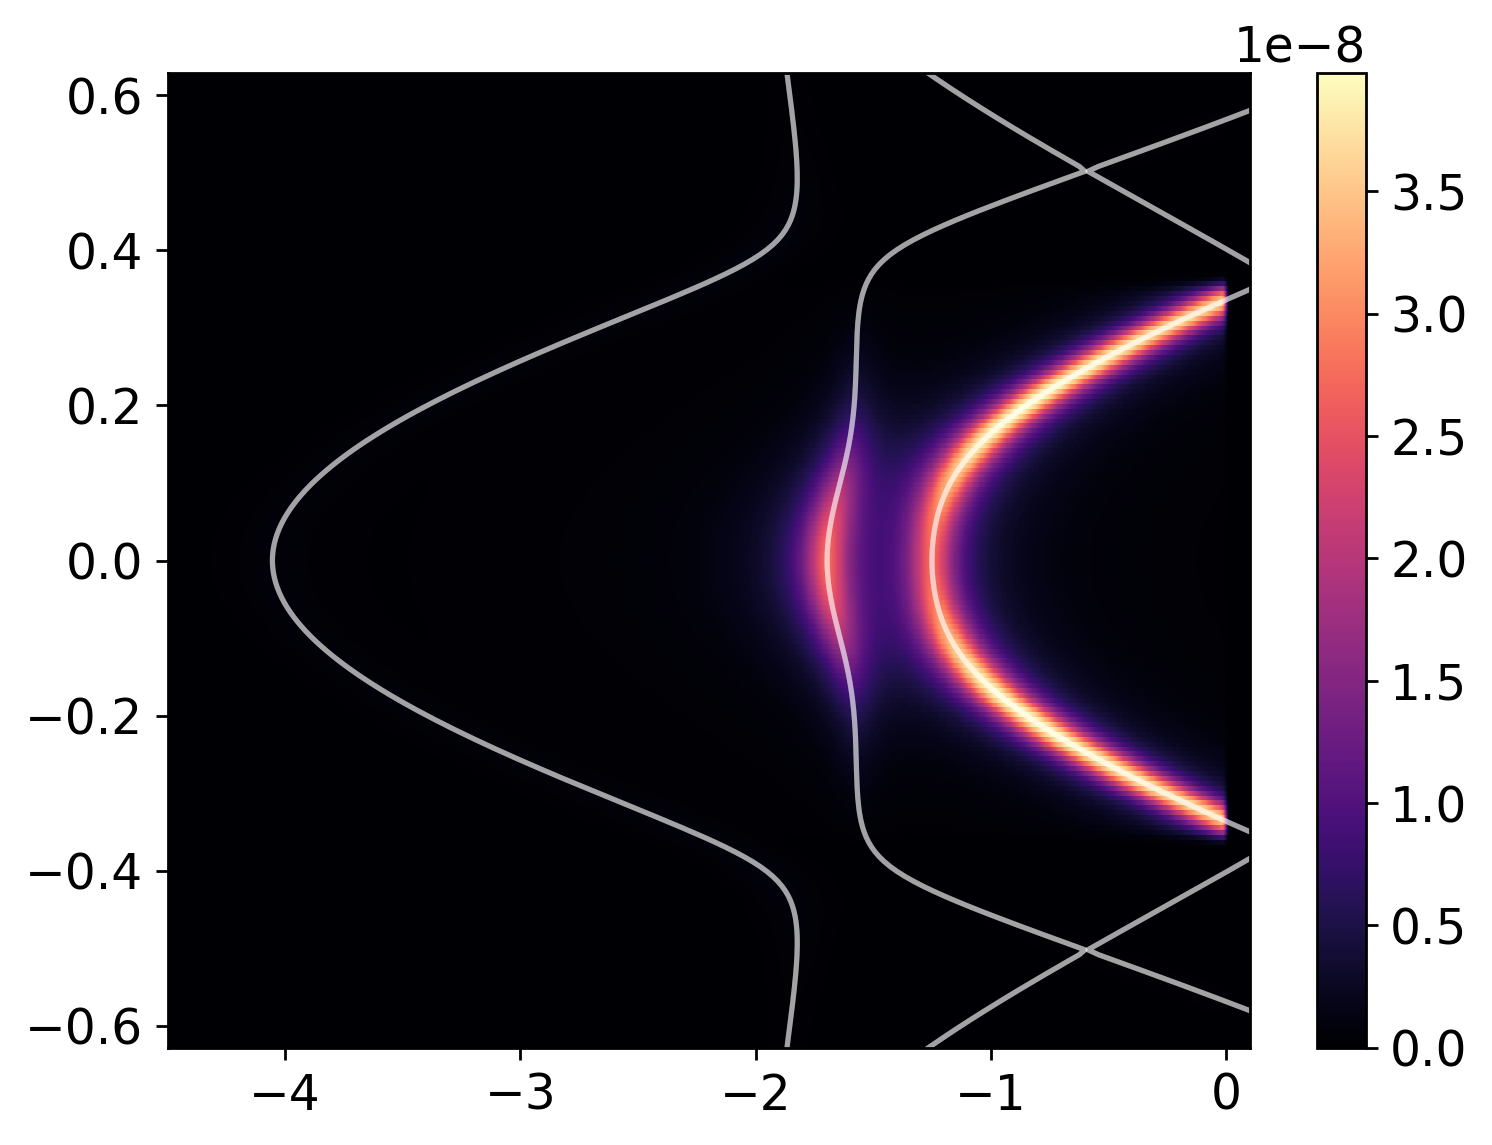

In [18]:
# 18) Change polarization again and re-plot
arpes['pol'] = np.array([0,1,0])
_ = arpes_experiment.spectral(arpes, slice_select=('y',0), plot_bands=True)